# Data cleaning and feature engineering

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('Pastel1')  
from scipy.stats import chi2_contingency
import statsmodels.api

# afficher seulement les minutes et secondes
import matplotlib.dates as md
from matplotlib.dates import MinuteLocator
ms_form = md.DateFormatter('%M:%S')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

BEST_PLAYERS =['Kobe Bryant', 'LeBron James', 'Stephen Curry', 'Kevin Durant', 'Dwyane Wade', 'Dirk Nowitzki', 'Tim Duncan', "Shaquille O'Neal", "Steve Nash", "Kawhi Leonard", "James Harden", "Jason Kidd", "Allen Iverson", "Chris Webber", "Kevin Garnett", "Paul Pierce", "Giannis Antetokounmpo", "Jimmy Butler", "Russell Westbrook", "Dwight Howard"]
PLAYERS_DICT = {
    'K. Bryant':'Kobe Bryant', 
    'L. James':'LeBron James', 
    'S. Curry':'Stephen Curry', 
    'K. Durant':'Kevin Durant', 
    'D. Wade':'Dwyane Wade', 
    'D. Nowitzki':'Dirk Nowitzki', 
    'T. Duncan':'Tim Duncan', 
    "S. O'Neal":"Shaquille O'Neal", 
    'S. Nash':"Steve Nash", 
    'K. Leonard':"Kawhi Leonard", 
    'J. Harden':"James Harden", 
    'J. Kidd':"Jason Kidd", 
    'A. Iverson':"Allen Iverson", 
    'C. Webber':"Chris Webber", 
    'K. Garnett':"Kevin Garnett", 
    'P. Pierce':"Paul Pierce", 
    'G. Antetokounmpo':"Giannis Antetokounmpo", 
    'J. Butler':"Jimmy Butler", 
    'R. Westbrook':"Russell Westbrook", 
    'D. Howard':"Dwight Howard"
}

def drop_players(data):
    """ Detele players that are not part of the study
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.PLAYER1_NAME.isin(BEST_PLAYERS)]

    return data


def drop_actions(data):
    """ Delete actions that are not shots (rebounds, violations, fouls, timeouts, etc.)
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """
    data = data[data.EVENTMSGTYPE < 4]
    return data 

def update_freethrow_outcome(data):
    """ Update the outcome of a free throw, checks if SCORE is updated. The score is updated only if the goal is made
    Args: 
        data : DataFrame
    Returns:
        data : DataFrame
    """      
    data.loc[(data.EVENTMSGTYPE==3) & (data.SCORE.isna()), 'EVENTMSGTYPE'] = 2  # MISSED
    data.loc[(data.EVENTMSGTYPE==3) & (data.SCORE.notna()), 'EVENTMSGTYPE'] = 1 # MADE
    return data

# def create_playsathome_feature(data):
#     data.loc[(data.HOMEDESCRIPTION.str.contains('3PT')) | (data.VISITORDESCRIPTION.str.contains('3PT')), '3PT'] = 1
#     data.loc[data['3PT'].isna(), '3PT'] = 0
#     return data

def create_3pt_feature(data):
    data.loc[(data.HOMEDESCRIPTION.str.contains('3PT')) | (data.VISITORDESCRIPTION.str.contains('3PT')), '3PT'] = 1
    data.loc[data['3PT'].isna(), '3PT'] = 0
    return data

def create_jumpshot_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Jump Shot')) | (data.VISITORDESCRIPTION.str.contains('Jump Shot')), 'jump_shot'] = 1
    data.loc[data['jump_shot'].isna(), 'jump_shot'] = 0
    return data

def create_layup_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Layup')) | (data.VISITORDESCRIPTION.str.contains('Layup')), 'layup_shot'] = 1
    data.loc[data['layup_shot'].isna(), 'layup_shot'] = 0
    return data

def create_dunk_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Dunk')) | (data.VISITORDESCRIPTION.str.contains('Dunk')), 'dunk_shot'] = 1
    data.loc[data['dunk_shot'].isna(), 'dunk_shot'] = 0
    return data

def create_hook_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Hook')) | (data.VISITORDESCRIPTION.str.contains('Hook')), 'hook_shot'] = 1
    data.loc[data['hook_shot'].isna(), 'hook_shot'] = 0
    return data

def create_freethrow_feature(data):    
    data.loc[(data.HOMEDESCRIPTION.str.contains('Free Throw')) | (data.VISITORDESCRIPTION.str.contains('Free Throw')), 'free_throw'] = 1
    data.loc[data['free_throw'].isna(), 'free_throw'] = 0
    return data

def clean_data(data):
    # Change index
    data = data.set_index(['GAME_ID', 'EVENTNUM'])

    # Create feature at_home to see if players perform better when they're at home
    data.loc[data.HOMEDESCRIPTION.notna(), 'at_home'] = 1
    data.loc[data.HOMEDESCRIPTION.isna(), 'at_home'] = 0

    data.loc[data.HOMEDESCRIPTION.isna(), 'HOMEDESCRIPTION'] = ''
    data.loc[data.VISITORDESCRIPTION.isna(), 'VISITORDESCRIPTION'] = ''

    data = drop_players(data)
    data = drop_actions(data)
    data = update_freethrow_outcome(data)
    
    # Transform EVENTMSGTYPE to have 0 = MISSED and 1 = MADE
    data.loc[data.EVENTMSGTYPE==2, 'EVENTMSGTYPE'] = 0
    
    # Create features from HOMEDESCRIPTION and VISITORDESCRIPTION
    data = create_3pt_feature(data)
    data = create_jumpshot_feature(data)
    data = create_layup_feature(data)
    data = create_dunk_feature(data)
    data = create_hook_feature(data)
    data = create_freethrow_feature(data)

    # Transform PCTIMESTRING as time
    data.PCTIMESTRING = pd.to_datetime(data.PCTIMESTRING, format="%M:%S") 

    # Create features from PCTIMESTRING
    data['minutes_left'] = data['PCTIMESTRING'].dt.minute
    data['seconds_left'] = data['PCTIMESTRING'].dt.minute*60 + data['PCTIMESTRING'].dt.second
    

    # Drop columns
    data = data.drop(['HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', \
                    'PLAYER2_TEAM_CITY', 'PLAYER2_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER1_ID', 'PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_ID','PLAYER2_TEAM_NICKNAME', \
                    'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', \
                    'SCOREMARGIN', 'VISITORDESCRIPTION', 'WCTIMESTRING', 'EVENTMSGACTIONTYPE', 'PCTIMESTRING'], axis = 1)
    
    # Rename target column
    data = data.rename({'EVENTMSGTYPE': 'target'}, axis=1)

    return data

def clean_data_new_format(data):
    # Time
    data['seconds_left'] = data['SecLeft']
    data['minutes_left'] = data['SecLeft'] // 60

    # Drop if not a shoot
    data = data[data.ShotOutcome.notna() | data.FreeThrowOutcome.notna()]

    # Replace miss = 0 and made = 1
    data['ShotOutcome'] = data['ShotOutcome'].replace({'miss':0, 'make':1})
    data['FreeThrowOutcome'] = data['FreeThrowOutcome'].replace({'miss':0, 'make':1})

    # Rename Shooter to fit the previous data format "Firstname Surname"
    data.Shooter = data.Shooter.str.split('-', expand=True)[0].str.rstrip().replace(PLAYERS_DICT)
    data.FreeThrowShooter = data.FreeThrowShooter.str.split('-', expand=True)[0].str.rstrip().replace(PLAYERS_DICT)

    # Drop if not on our BEST_PLAYERS list
    data = data[data.Shooter.isin(BEST_PLAYERS) | data.FreeThrowShooter.isin(BEST_PLAYERS)]

    # We keep only one column for the shooter
    data.loc[data.Shooter.isna(), 'Shooter'] = data.loc[data.FreeThrowShooter.notna(), 'FreeThrowShooter']
    # And one column for the outcome
    data.loc[data.ShotOutcome.isna(), 'ShotOutcome'] = data.loc[data.FreeThrowOutcome.notna(), 'FreeThrowOutcome']

    # Create features : PLAYER1_TEAM_NICKNAME	3PT	jump_shot	layup_shot	dunk_shot	hook_shot	free_throw
    data.loc[data.ShotType.isna(), 'ShotType'] = ''

    data.loc[data.ShotType.str.contains('3-pt'), '3PT'] = 1
    data.loc[data['3PT'].isna(), '3PT'] = 0

    data.loc[data.ShotType.str.contains('jump'), 'jump_shot'] = 1
    data.loc[data['jump_shot'].isna(), 'jump_shot'] = 0

    data.loc[data.ShotType.str.contains('layup'), 'layup_shot'] = 1
    data.loc[data['layup_shot'].isna(), 'layup_shot'] = 0

    data.loc[data.ShotType.str.contains('dunk'), 'dunk_shot'] = 1
    data.loc[data['dunk_shot'].isna(), 'dunk_shot'] = 0

    data.loc[data.ShotType.str.contains('hook'), 'hook_shot'] = 1
    data.loc[data['hook_shot'].isna(), 'hook_shot'] = 0

    data.loc[data.FreeThrowOutcome.notna(), 'free_throw'] = 1
    data.loc[data['free_throw'].isna(), 'free_throw'] = 0

    data.loc[data.AwayPlay.notna(),'PLAYER1_TEAM_ABBREVIATION'] = data.loc[data.AwayPlay.notna(),'AwayTeam']
    data.loc[data.HomePlay.notna(),'PLAYER1_TEAM_ABBREVIATION'] = data.loc[data.HomePlay.notna(),'HomeTeam']

    # Rename columns to fit the previous data format
    data = data.rename({'ShotOutcome': 'target', 
                        'Quarter':'PERIOD',
                        'Shooter': 'PLAYER1_NAME',
                        'Game ID':'GAME_ID',	
                        'Game Event ID':'EVENTNUM'	
                        }, axis=1)

    # Create empty column PERSON1TYPE
    data['PERSON1TYPE'] = 0

    # Create feature at_home to see if players perform better when they're at home
    data.loc[data.HomePlay.notna(), 'at_home'] = 1
    data.loc[data.HomePlay.isna(), 'at_home'] = 0
    
    # Drop columns
    data = data.drop(['Unnamed: 0', 'Unnamed: 40', 'GameType', 'Location', 'Date', 'Time', 'WinningTeam', 'SecLeft', 'AwayTeam', 'AwayPlay',
                      'AwayScore', 'HomeTeam', 'HomePlay', 'HomeScore', 'ShotType', 'ShotDist', 'Assister', 
                      'Blocker', 'FoulType', 'Fouler', 'Fouled', 'Rebounder', 'ReboundType', 'ViolationPlayer', 'ViolationType', 
                      'TimeoutTeam', 'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum', 'EnterGame','LeaveGame','TurnoverPlayer',
                      'TurnoverType','TurnoverCause','TurnoverCauser','JumpballAwayPlayer','JumpballHomePlayer','JumpballPoss'], axis = 1)
    
    # Change index
    data = data.set_index(['GAME_ID', 'EVENTNUM'])
    # Change column order
    data = data.reindex(['target','PERIOD','PERSON1TYPE','PLAYER1_NAME','PLAYER1_TEAM_ABBREVIATION','at_home','3PT','jump_shot','layup_shot','dunk_shot','hook_shot','free_throw','minutes_left','seconds_left'], axis=1)
    
    return data

In [286]:
# Clean all datasets from 2000 to 2019
files = ['2000-01_pbp.csv','2001-02_pbp.csv','2002-03_pbp.csv','2003-04_pbp.csv','2004-05_pbp.csv',
         '2005-06_pbp.csv','2006-07_pbp.csv','2007-08_pbp.csv','2008-09_pbp.csv','2009-10_pbp.csv',
         '2010-11_pbp.csv','2011-12_pbp.csv','2012-13_pbp.csv','2013-14_pbp.csv','2014-15_pbp.csv',
         '2015-16_pbp.csv','2016-17_pbp.csv','2017-18_pbp.csv','2018-19_pbp.csv']

all_data = []

for file in files:
    data = pd.read_csv("../data/raw/"+file, index_col=0)
    all_data.append(clean_data(data))

# Clean and add dataset for season 2019-2020 which has a different format
df2020 = pd.read_csv("../data/raw/2019-20_pbp_U.csv")
all_data.append(clean_data_new_format(df2020))

# Concat everything
all_plays = pd.concat(all_data)

In [287]:
all_plays.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 393787 entries, (20001116, 2) to (21900968, 650)
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   target                     393787 non-null  float64
 1   PERIOD                     393787 non-null  int64  
 2   PERSON1TYPE                393787 non-null  float64
 3   PLAYER1_NAME               393787 non-null  object 
 4   PLAYER1_TEAM_ABBREVIATION  393787 non-null  object 
 5   at_home                    393787 non-null  float64
 6   3PT                        393787 non-null  float64
 7   jump_shot                  393787 non-null  float64
 8   layup_shot                 393787 non-null  float64
 9   dunk_shot                  393787 non-null  float64
 10  hook_shot                  393787 non-null  float64
 11  free_throw                 393787 non-null  float64
 12  minutes_left               393787 non-null  int64  
 13  seconds_

In [288]:
all_plays.to_csv("../data/processed/PlaybyPlay_2000-2020.csv")

## Data Visualization

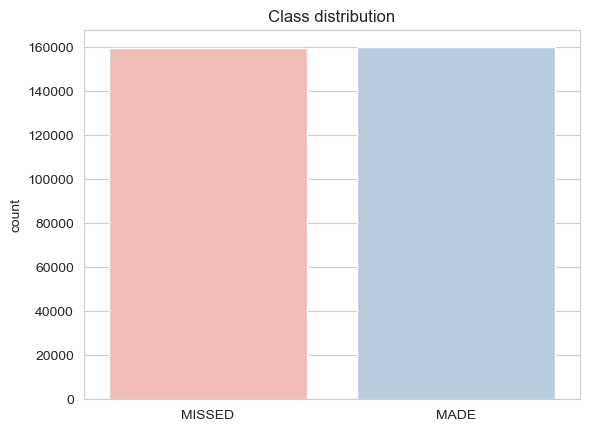

In [273]:
# Check class distribution
sns.countplot(data=all_plays, x='target')
plt.title("Class distribution")
plt.xticks([0,1], labels=['MISSED', 'MADE'])
plt.xlabel('')
plt.show()

The classes are balanced

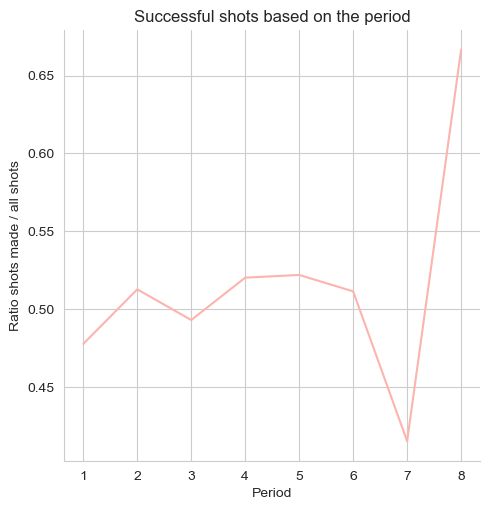

In [274]:
reussis = all_plays[all_plays.target==1].groupby(['PERIOD'])['target'].agg('count')
rates = all_plays[all_plays.target==0].groupby(['PERIOD'])['target'].agg('count')
moyenne = all_plays[all_plays.target==1].groupby(['PERIOD']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)

sns.relplot(moyenne, x='PERIOD', y='RATIO', kind='line')
plt.title("Successful shots based on the period")
plt.xlabel("Period")
plt.ylabel("Ratio shots made / all shots")
plt.show()

Success seems to increase over time

In [275]:
# Correlation test target vs period
ct = pd.crosstab(all_plays.target, all_plays.PERIOD)
res = chi2_contingency(ct)
print("Test statistic =", res[0])
print("p-value =", res[1])

print("The p-value is less than 5%, so we can conclude that the is not independent of the period.")

Test statistic = 359.0628334521601
p-value = 1.4136021116407565e-73
The p-value is less than 5%, so we can conclude that the is not independent of the period.


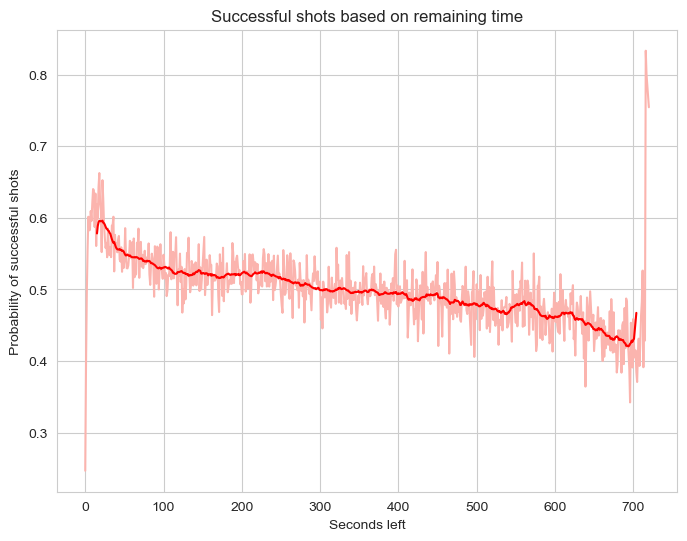

In [276]:
reussis = all_plays[all_plays.target==1].groupby(['seconds_left'])['target'].agg('count')
rates = all_plays[all_plays.target==0].groupby(['seconds_left'])['target'].agg('count')
moyenne = all_plays[all_plays.target==1].groupby(['seconds_left']).agg('count')
moyenne['RATIO']= reussis / (rates+reussis)

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(moyenne, x='seconds_left', y='RATIO', ax=ax)
plt.title("Successful shots based on remaining time")
plt.xlabel("Seconds left")
plt.ylabel("Probability of successful shots")

mean = moyenne['RATIO'].rolling(window=30, center=True).mean()
plt.plot(mean, color="red")

plt.show()

In [277]:
# Test correlation with ANOVA
result = statsmodels.formula.api.ols('seconds_left ~ target', data=all_plays).fit()
statsmodels.api.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
target,1.0,4.348334e+07,4.348334e+07,1042.279707,2.713987e-228
Residual,319356.0,1.332336e+10,4.171946e+04,NaN,NaN


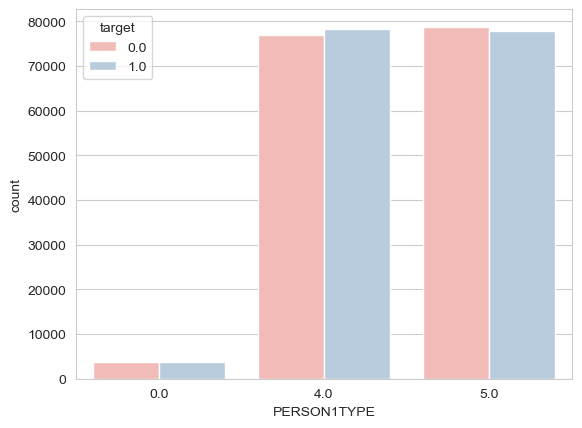

In [278]:
sns.countplot(data=all_plays, x='PERSON1TYPE', hue='target')
plt.show()

In [279]:
# Correlation test target vs person1type
ct = pd.crosstab(all_plays.target, all_plays.PERSON1TYPE)
res = chi2_contingency(ct)
print("Statistique du test =", res[0])
print("p-valeur =", res[1])

print("The p-value is less than 5%, so we can conclude that target is not independent of the person1type variable.")

Statistique du test = 18.677348567410213
p-valeur = 8.795596348266803e-05
The p-value is less than 5%, so we can conclude that target is not independent of the person1type variable.


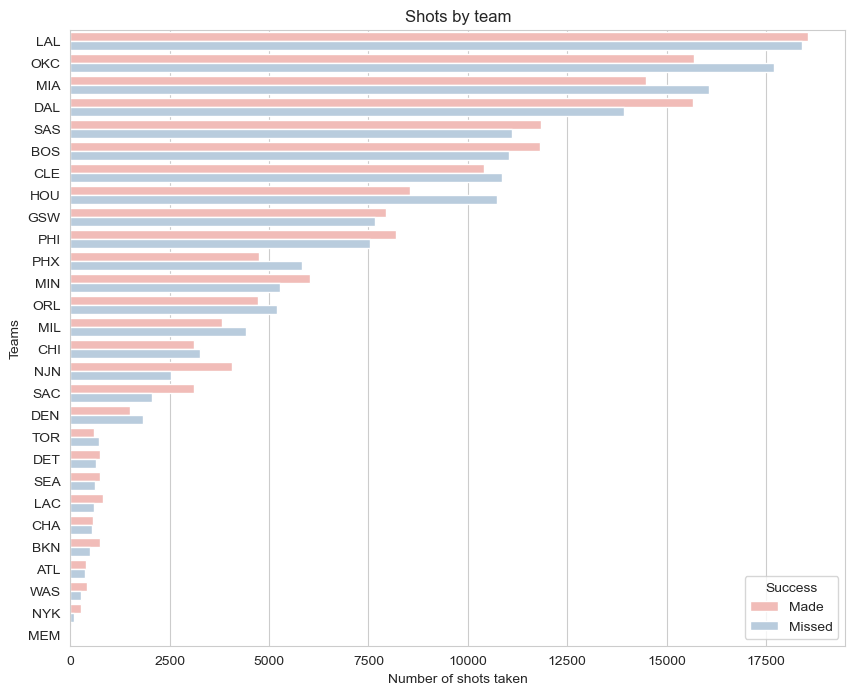

In [280]:
# success by team
plt.figure(figsize=(10,8))

plot = sns.countplot(data=all_plays, 
                     y='PLAYER1_TEAM_ABBREVIATION', 
                     hue='target', 
                     order=all_plays[all_plays.target==1]['PLAYER1_TEAM_ABBREVIATION'].value_counts().index)
plt.title('Shots by team')
plt.ylabel('Teams')
plt.xlabel('Number of shots taken')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Success')
new_labels = ['Made', 'Missed']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

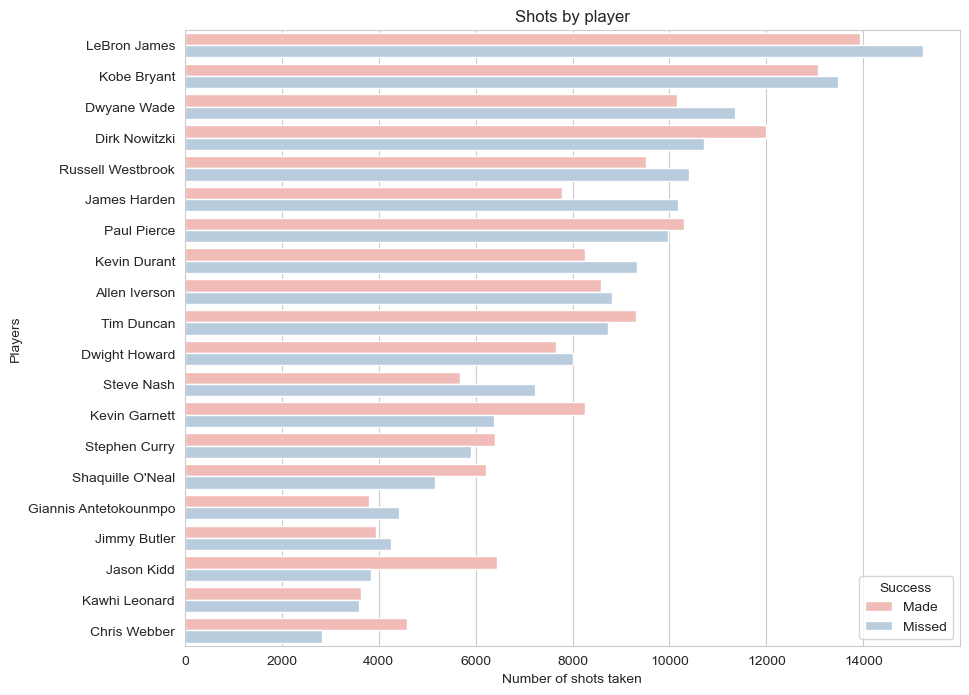

In [281]:
# success by player
plt.figure(figsize=(10,8))

plot = sns.countplot(data=all_plays, 
                     y='PLAYER1_NAME', 
                     hue='target', 
                     order=all_plays[all_plays.target==1]['PLAYER1_NAME'].value_counts().index)
plt.title('Shots by player')
plt.ylabel('Players')
plt.xlabel('Number of shots taken')

# Légende 
leg = plot.axes.get_legend()
leg.set_title('Success')
new_labels = ['Made', 'Missed']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

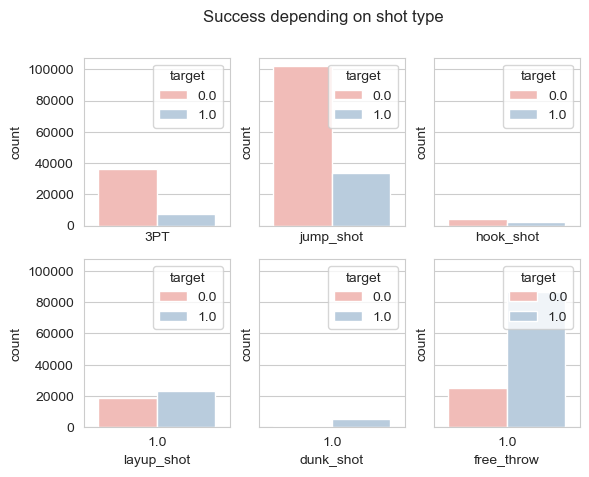

In [283]:
# Success by type of shots
fig, axes = plt.subplots(2,3,sharey=True, sharex=True)

sns.countplot(data=all_plays[all_plays['3PT']==1], x='3PT', hue='target', ax=axes[0,0])
sns.countplot(data=all_plays[all_plays.jump_shot==1], x='jump_shot', hue='target', ax=axes[0,1])
sns.countplot(data=all_plays[all_plays.hook_shot==1], x='hook_shot', hue='target', ax=axes[0,2])
sns.countplot(data=all_plays[all_plays.layup_shot==1], x='layup_shot', hue='target', ax=axes[1,0])
sns.countplot(data=all_plays[all_plays.dunk_shot==1], x='dunk_shot', hue='target', ax=axes[1,1])
sns.countplot(data=all_plays[all_plays.free_throw==1], x='free_throw', hue='target', ax=axes[1,2])

fig.suptitle("Success depending on shot type")
plt.show()

<Axes: xlabel='target', ylabel='count'>

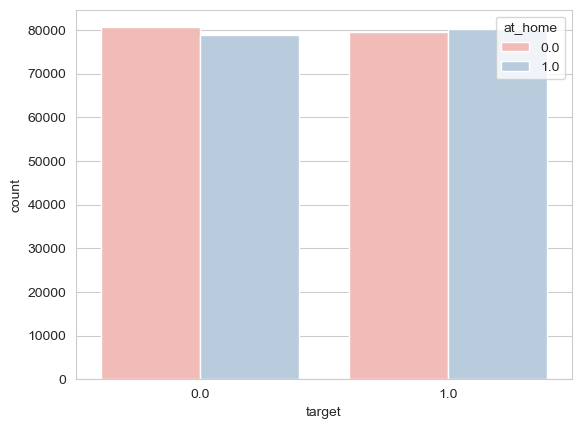

In [284]:
sns.countplot(data=all_plays, x='target', hue='at_home')

# Predictions

In [9]:
# prepare data for modeling
df = pd.get_dummies(all_plays)

X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# réduction de dimensions
sel = SelectKBest(score_func = chi2)
sel.fit(X_train, y_train)
mask = sel.get_support()

X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)

In [10]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)

print('Accuracy with RandomForest:', accuracy_score(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Accuracy with RandomForest: 0.6576364161293426


Classe prédite,0,1
Classe réelle,,
0,20274,10812
1,10533,20727


In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=.1, objective='binary:logistic')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print('Accuracy with XGBoost:', accuracy_score(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Accuracy with XGBoost: 0.7267988323228435


Classe prédite,0,1
Classe réelle,,
0,21724,9362
1,7671,23589
